### Environment Setup

#### Load up root folder

In [0]:
import os
root = './' # Root should be your project folder
os.chdir(root)
os.getcwd()

#### User Defined Parameters

In [0]:
# Model Parameters
nb_classes = 1
batch_size = 8
nb_epoch = 32
depth = 169
nb_dense_block = 4
nb_filter = 64
growth_rate = 32
dropout_rate = 0.0
learning_rate = 1e-4
weights = 'imagenet'
weight_decay = 1e-4
concat_axis = 3
db_layers169 = [6, 12, 32, 32]
kern_init = 'he_uniform'
reduction = 0.5
compression = 1.0 - reduction # Compression Factor
plot = False

# Model Optimizer (Kingma & Ba, 2014)
beta1=0.9
beta2=0.999

# Input Img Dim
im_size = 320
img_dim = (im_size, im_size,3)

#### Load Packages

In [0]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, cohen_kappa_score, accuracy_score, classification_report

from keras.models import Model
from keras.layers import Input, Dense, Conv2D
from keras.layers import MaxPooling2D, GlobalMaxPooling2D
from keras.layers import AveragePooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Dropout, Activation, concatenate
from keras.regularizers import l2
import keras.backend as K
from keras.applications.densenet import DenseNet169
from keras.optimizers import Adam

%matplotlib inline

In [0]:
# Suppress Tensorflow Deprecation Warnings
import logging
logging.getLogger('tensorflow').disabled = True

### Do not modify below

### Pre-Defined Functions

#### Functions for image loading and pre-processing

In [0]:
def load_path(root_path = root+'/train/XR_ELBOW', size=320):
  Imglist = []
  Labels = []
  for rt, _, files in os.walk(root_path):
    for file in files:
      filepath = os.path.join(rt, file)
      Imglist.append(filepath)
      if rt.split('_')[-1] == 'positive':
        Labels+=[1]
      else:
        Labels+=[0]
      
  print("Total No. of Images: ", len(Imglist))
  print("Total No. of Normal Images: ", Labels.count(0))
  print("Total No. of Abnormal Images: ", Labels.count(1))
  
  Labels = np.asarray(Labels)
  return Imglist, Labels

In [0]:
def img_augment(image, size=320):
  random.seed(88)
  if random.randint(0,1):
    image = cv2.flip(image,1)
    
  if random.randint(0,1):
    angle = random.randint(-30,30)
    M = cv2.getRotationMatrix2D((im_size/2, im_size/2), angle, 1)
    image = cv2.warpAffine(image, M, (im_size, im_size))
    
  return image

In [0]:
def load_image(root_path = root+'valid_images', size=320):
  Images = []
  for path in root_path:
    image = cv2.imread(path)
    image = cv2.resize(image, (size, size))
    image = img_augment(image, size) # Random lateral flip and rotation
    Images.append(image)
    
  Images = np.asarray(Images).astype('float32')
    
  return Images

#### DenseNet Model

In [0]:
def name_or_none(prefix, name):
    return prefix + name if (prefix is not None and name is not None) else None

In [0]:
def convblock(x, concat_axis, nb_filter, dropout_rate=None, 
              weight_decay=1e-4, block_prefix=None):
  
  # BN-RELU-Conv(1x1)-BN-RELU-Conv(3x3) (Huang et al., 2016)
  
  with K.name_scope('ConvBlock'):
    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5, name=name_or_none(block_prefix, '_bn'))(x)
    x = Activation('relu')(x)
    
    # Bottleneck Layer
    inter_channel = nb_filter * 4
    x = Conv2D(inter_channel,
               (1, 1),
               kernel_initializer=kern_init,
               padding='same',
               use_bias=False,
               kernel_regularizer=l2(weight_decay),
               name=name_or_none(block_prefix, '_bottleneck_conv2D'))(x)
    x = BatchNormalization(axis=concat_axis, 
                           epsilon=1.1e-5,
                           name=name_or_none(block_prefix, '_bottleneck_bn'))(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter,
               (3, 3),
               kernel_initializer=kern_init,
               padding='same',
               use_bias=False,
               kernel_regularizer=l2(weight_decay),
               name=name_or_none(block_prefix, '_conv2D'))(x)
    
    if dropout_rate:
      x = Dropout(dropout_rate)(x)
      
    return x

In [0]:
def denseblock(x, concat_axis, nb_layers, nb_filter, growth_rate,
               dropout_rate=None, weight_decay=1e-4, 
               grow_nb_filters=True, block_prefix=None):
  
  with K.name_scope('DenseBlock'):
    x_list = [x]

    for i in range(nb_layers):
      cb = convblock(x, concat_axis, growth_rate, dropout_rate, weight_decay,
                      block_prefix=name_or_none(block_prefix, '_%i' %i))
      x_list.append(cb)
      x = concatenate([x, cb], axis=concat_axis)
      
      if grow_nb_filters:
        nb_filter += growth_rate
        
    return x, nb_filter

In [0]:
def transition(x, concat_axis, nb_filter, dropout_rate=None, 
               weight_decay=1e-4, compression=1.0, block_prefix=None):

  with K.name_scope('Transition'):
    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5, name=name_or_none(block_prefix, '_bn'))(x)
    x = Activation('relu')(x)
    
    x = Conv2D(int(nb_filter*compression),
             (1, 1),
             kernel_initializer=kern_init,
             padding='same',
             use_bias=False,
             kernel_regularizer=l2(weight_decay),
             name=name_or_none(block_prefix, '_transition_conv2D'))(x)
    
    if dropout_rate:
      x = Dropout(dropout_rate)(x)
      
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)
    
    return x

In [0]:
def DenseNet(nb_classes=1000, img_dim=None, depth=169, nb_dense_block=4,
             growth_rate=12, nb_filter=16, nb_layers_per_block=None,
             dropout_rate=0.0, weight_decay=1e-4, compression=1.0):
  
  # Define the number of layers in each dense block
  if nb_layers_per_block == None:
    assert (depth - 4) % 3 == 0;
    nb_layers = [int((depth - 4)/3)]*nb_dense_block
  else:
    nb_layers = nb_layers_per_block
  
  with K.name_scope('DenseNet'):
    
    model_input = Input(shape=img_dim)
    
#     print(model_input)
    
    # Initial Convolution
    x = Conv2D(nb_filter, (7,7),
               strides=(2,2),
               kernel_initializer=kern_init,
               padding="same",
               name="Init_Conv2D",
               use_bias=False,
               kernel_regularizer=l2(weight_decay))(model_input)
    
    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5,
                           name='initial_bn')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    
    # Add Dense Blocks with Transition (i.e. Block 1, 2 and 3)
    for block_idx in range(nb_dense_block - 1):
      x, nb_filter = denseblock(x, concat_axis,nb_layers[block_idx],
                               nb_filter, growth_rate,
                               dropout_rate=dropout_rate,
                               weight_decay=weight_decay,
                               block_prefix='dense_%i' % block_idx)
      x = transition(x, concat_axis, nb_filter,
                     dropout_rate=dropout_rate, weight_decay=weight_decay,
                     compression=compression,
                     block_prefix='tr_%i' % block_idx)
      nb_filter = int(nb_filter * compression)
      
    # Last DenseBlock (i.e. Block 4 in a 169-layered architecture)
    x, nb_filter = denseblock(x, concat_axis, nb_layers[nb_dense_block-1],
                              nb_filter, growth_rate, dropout_rate=dropout_rate,
                              weight_decay=weight_decay,
                              block_prefix='dense_%i' % (nb_dense_block - 1))
    
    x = BatchNormalization(axis=concat_axis, 
                           gamma_regularizer=l2(weight_decay),
                           beta_regularizer=l2(weight_decay),
                           name='final_bn')(x)
    x = Activation('relu')(x)
    
    # Global Average Pooling and Classification Layer using Sigmoid function
    x = GlobalAveragePooling2D(data_format=K.image_data_format())(x)
    x = Dense(nb_classes,
              activation='sigmoid',
              kernel_regularizer=l2(weight_decay),
              bias_regularizer=l2(weight_decay))(x)
    
    densenet_top = Model(inputs=model_input, outputs=x, name="DenseNet")
    densenet_top.load_weights('./saved_models/best_MURA_model_ave_wrist.h5') # Pre-Trained Wrist-Only Model
    
    return densenet_top

#### Model Performance Metrics

In [0]:
def mdl_metrics(mdl,pred, truth):
  actual = np.where(model.predict(pred) > 0.5, 1, 0)
  predicted = truth 
  results = confusion_matrix(actual, predicted) 
  print ('Confusion Matrix :')
  print(results) 
  print ('Accuracy Score :', round(accuracy_score(actual, predicted),3))
  print ('Cohen Kappa :', round(cohen_kappa_score(actual, predicted),3))
  print ('Report : ')
  print (classification_report(actual, predicted))

#### Model Prediction

In [0]:
def predict(valid_img, im_idx):
  result = round(model.predict(valid_img)[im_idx][0],3)
  if result > 0.5:
    print("Image is abnormal (Prob:", result,")")
  else:
    print("Image is normal (Prob:", result,")")

#### Layer-wise Activation Visualization

In [0]:
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]

    activation_index=0
    act_pixel_percentage = []
    ranked_index=[]

    for i in range(0,activation.shape[3]):
      min = np.min(activation[0,:,:,i])
      max = np.max(activation[0,:,:,i])
      act_pixel_percentage.append((activation[0,:,:,i]>(max-min)*0.75).sum())

    act_arr = np.array(act_pixel_percentage)[::]
    ranked_index=np.argsort(-act_arr)

    act_idx=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(10, 10))
#     fig.tight_layout()
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, ranked_index[act_idx]],  cmap='bwr')
            ax[row,col].axis('off')
            act_idx += 1

#### Class Activation Map

In [0]:
def CAM(mdl, valid_img, im_idx):
  act_layer = mdl.get_layer('activation_169')
  model_nt = Model(inputs=mdl.input, outputs=act_layer.output)

  final_dense = model.get_layer('dense_1')
  fW = final_dense.get_weights()[0]
  fmaps = model_nt.predict(valid_img)[im_idx]

  cam = fmaps.dot(fW)
  cam = sp.ndimage.zoom(cam, (32,32,1), order=1)
  cam = cam.squeeze()

  image = cv2.cvtColor(valid_img[im_idx], cv2.COLOR_BGR2GRAY)
  fig= plt.figure(figsize=(10,10))
  image = cv2.resize(image, (320,320))
  plt.imshow(image, alpha=0.8);
  plt.imshow(cam, cmap='jet', alpha=0.2)
  plt.axis('off')
  plt.show()

### Load Images and Model

#### Model Construction

In [0]:
model = DenseNet(nb_classes=nb_classes, img_dim=img_dim, depth=depth, nb_dense_block=nb_dense_block, 
                 growth_rate=growth_rate, nb_filter=nb_filter, nb_layers_per_block=db_layers169,    
                 dropout_rate=dropout_rate, weight_decay=weight_decay, compression=compression)

In [0]:
# model.summary()

#### Load Images

In [0]:
img_folder = '/valid/XR_WRIST'
X_valid_path, Y_valid = load_path(root_path=root+img_folder, size=im_size)

Total No. of Images:  659
Total No. of Normal Images:  364
Total No. of Abnormal Images:  295


In [0]:
X_valid = load_image(root_path=X_valid_path, size=im_size)
Y_valid = np.asarray(Y_valid)

#### Model Performance

In [0]:
mdl_metrics(model,X_valid, Y_valid)

#### Interpretation Visualization Framework

In [0]:
# Image Index to be viewed
im=0
print(X_valid_path[im])

In [0]:
predict(X_valid, im)

Image is abnormal (Prob: 0.87 )


#### Layer-wise Activations

In [0]:
layer_outputs = [layer.output for layer in model.layers][1:]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_valid[im].reshape(1,320,320,3))

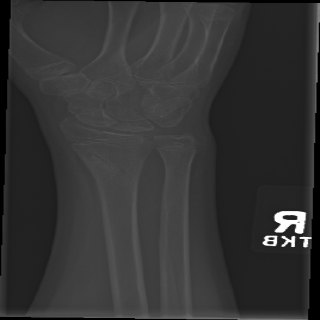

In [0]:
# Model Input (Augmented Image)
from google.colab.patches import cv2_imshow
cv2_imshow(X_valid[im]);

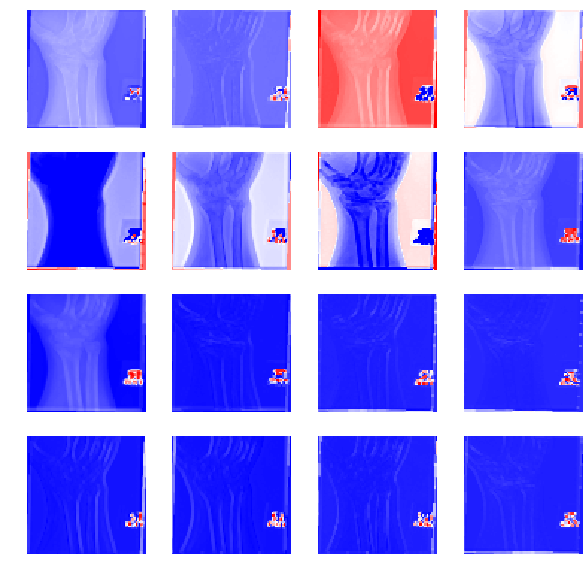

In [0]:
# Activations at end of Init Conv
display_activation(activations, 4, 4, 5)

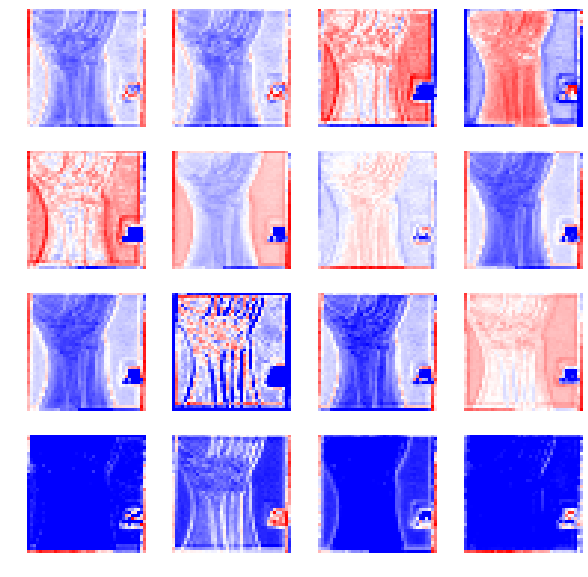

In [0]:
# Activations at end of Block 1
display_activation(activations, 4, 4, 54)

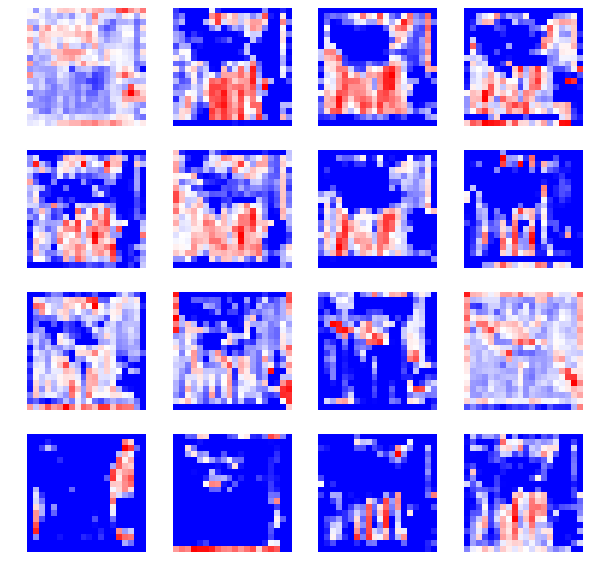

In [0]:
# Activations at end of Block 2
display_activation(activations, 4, 4, 142)

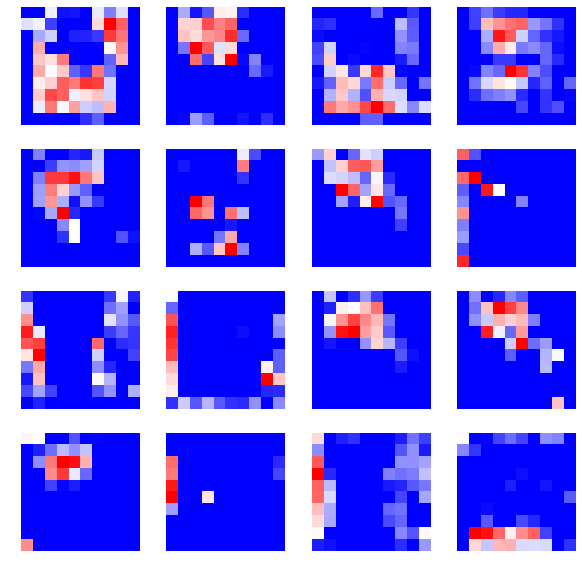

In [0]:
# Activations at end of Block 3
display_activation(activations, 4, 4, 370)

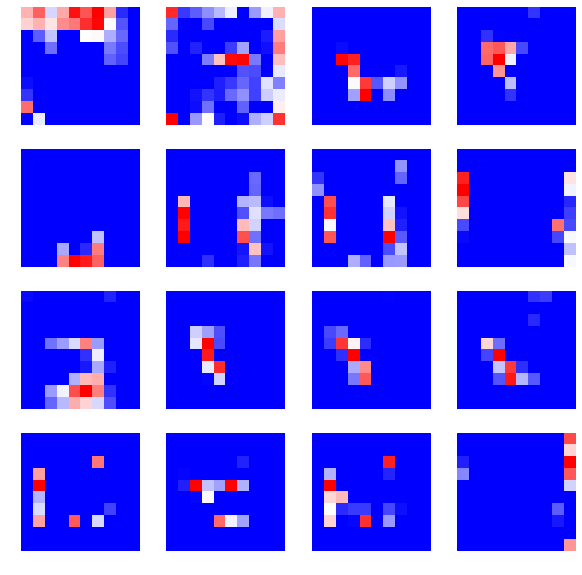

In [0]:
# Activations at end of Block 4
display_activation(activations, 4, 4, 587)

#### Class Activation Map (CAM)

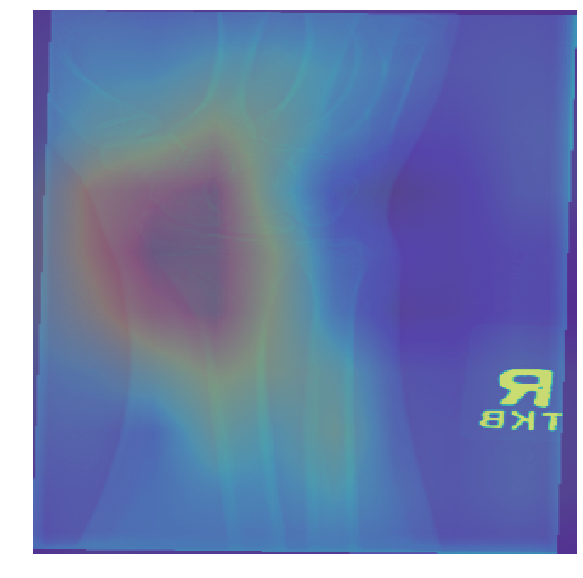

In [0]:
CAM(model, X_valid, im)